In [1]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import img_to_array, load_img


In [2]:
def preprocess_image(image_path):
    """Preprocess the image: resize, normalize, and flatten"""
    try:
        from tensorflow.keras.preprocessing.image import load_img, img_to_array
        
        img = load_img(image_path, target_size=(128, 128))
        img_array = img_to_array(img) / 255.0
        return img_array.flatten()
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

In [3]:
def find_image(folder, image_id):
    """Find image with flexible matching"""
    search_patterns = [
        os.path.join(folder, f"{image_id}.*"),
        os.path.join(folder, f"{image_id.lower()}.*"),
        os.path.join(folder, f"{image_id.upper()}.*"),
    ]
    
    for pattern in search_patterns:
        matching_files = glob.glob(pattern)
        if matching_files:
            return matching_files[0]
    return None


In [4]:


# File paths
data_path = "person.csv"
front_folder = r"C:\\Users\\thaku\\OneDrive\\Desktop\\PrmlProject\\front"
side_folder = r"C:\\Users\\thaku\\OneDrive\\Desktop\\PrmlProject\\side\\side"


# Load the data
data = pd.read_csv(data_path, sep=";")

# Select relevant columns and clean data
data = data[["id", "height", "weight", "sex"]]
data["sex"] = data["sex"].fillna("unknown").apply(lambda x: str(x).strip().lower())  # Handle invalid 'sex'
data = data[data["sex"].isin(["male", "female"])]  # Filter valid rows

# Convert height and weight to metric units, and calculate BMI
data["height"] = data["height"] * 0.0254  # 1 inch = 0.0254 meters
data["weight"] = data["weight"] * 0.453592  # 1 lb = 0.453592 kg
data["BMI"] = data["weight"] / (data["height"] ** 2)
data["sex"] = data["sex"].apply(lambda x: 1 if x == "male" else 0)  # Encode sex as binary

# Balance the dataset by sampling
females = data[data["sex"] == 0]
males = data[data["sex"] == 1].sample(4000, random_state=42)  # Randomly sample 4000 males
balanced_data = pd.concat([females, males], ignore_index=True)




# Filter rows for healthy individuals (BMI between 18.5 and 25)
healthy_data = balanced_data

# Initialize arrays and a list to store valid rows
front_images = []
side_images = []
valid_rows = []

# Loop through the healthy data rows
for _, row in healthy_data.iterrows():
    # Find images with flexible matching
    front_path = find_image(front_folder, str(row['id']))
    side_path = find_image(side_folder, str(row['id']))

    # Skip if either image is not found
    if not front_path or not side_path:
        continue

    # Preprocess images
    front_img = preprocess_image(front_path)
    side_img = preprocess_image(side_path)

    # Verify both images are processed
    if front_img is not None and side_img is not None:
        front_images.append(front_img)
        side_images.append(side_img)
        valid_rows.append(row)

# Convert lists to numpy arrays
front_images = np.array(front_images)
side_images = np.array(side_images)

# Filter valid rows to a DataFrame
valid_data = pd.DataFrame(valid_rows)

# Separate females and males
females = valid_data[valid_data["sex"] == 0]
males = valid_data[valid_data["sex"] == 1]


print(f"Only {len(males)} males  {len(females)} available, selecting all of them.")
selected_males = males  # Use all available males if less than 4000
# Update images for selected rows
final_data = pd.concat([females, selected_males], ignore_index=True)

# Step 7: Apply PCA to reduce dimensions
pca_front = PCA(n_components=100)
pca_side = PCA(n_components=100)
front_images_reduced = pca_front.fit_transform(front_images)
side_images_reduced = pca_side.fit_transform(side_images)

# Step 8: Add PCA-transformed data to the DataFrame
valid_data["front_image_data"] = list(front_images_reduced)
valid_data["side_image_data"] = list(side_images_reduced)






Only 2180 males  2480 available, selecting all of them.


In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, mean_absolute_error

# Preprocess the data - Filter rows with missing BMI or image data
valid_data = valid_data.dropna(subset=["BMI", "front_image_data", "side_image_data"])
print(f"Only {len(males)} males  {len(females)} females available, selecting all of them.")

# Prepare features and targets
X_front = np.array(valid_data["front_image_data"].tolist())
X_side = np.array(valid_data["side_image_data"].tolist())
X_combined = np.hstack((X_front, X_side))  # Combine front and side features
y_gender = valid_data["sex"].values
y_bmi = valid_data["BMI"].values

# Split the data for gender classification
X_train, X_test, y_gender_train, y_gender_test = train_test_split(
    X_combined, y_gender, test_size=0.2, random_state=42
)

# Gender Classification - Logistic Regression
gender_model = LogisticRegression(random_state=42, max_iter=1000)
gender_model.fit(X_train, y_gender_train)

# Predict and evaluate gender classification
y_gender_pred = gender_model.predict(X_test)
gender_accuracy = accuracy_score(y_gender_test, y_gender_pred)
gender_report = classification_report(y_gender_test, y_gender_pred)

print("Gender Classification Results:")
print(f"Accuracy: {gender_accuracy}")
print("Classification Report:")
print(gender_report)

# Split the data for BMI regression
X_train, X_test, y_bmi_train, y_bmi_test = train_test_split(
    X_combined, y_bmi, test_size=0.2, random_state=42
)

# Train BMI Prediction Model
bmi_model = LinearRegression()
bmi_model.fit(X_train, y_bmi_train)

# Predict and evaluate BMI regression
y_bmi_pred = bmi_model.predict(X_test)
bmi_mse = mean_squared_error(y_bmi_test, y_bmi_pred)
bmi_mae = mean_absolute_error(y_bmi_test, y_bmi_pred)
bmi_r2 = bmi_model.score(X_test, y_bmi_test)

print("\nBMI Prediction Results (Filtered Data):")
print(f"Mean Squared Error: {bmi_mse}")
print(f"Mean Absolute Error: {bmi_mae}")
print(f"R-squared Score: {bmi_r2}")

import joblib
joblib.dump(bmi_model, 'bmi_regression_model_filtered.pkl')
valid_data.to_pickle("preprocessed_data_filtered.pkl")


Only 2180 males  2480 females available, selecting all of them.
Gender Classification Results:
Accuracy: 0.9375
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       511
           1       0.92      0.94      0.93       417

    accuracy                           0.94       928
   macro avg       0.94      0.94      0.94       928
weighted avg       0.94      0.94      0.94       928


BMI Prediction Results (Filtered Data):
Mean Squared Error: 33.783560804847745
Mean Absolute Error: 4.4748002583837785
R-squared Score: 0.18632618458384165


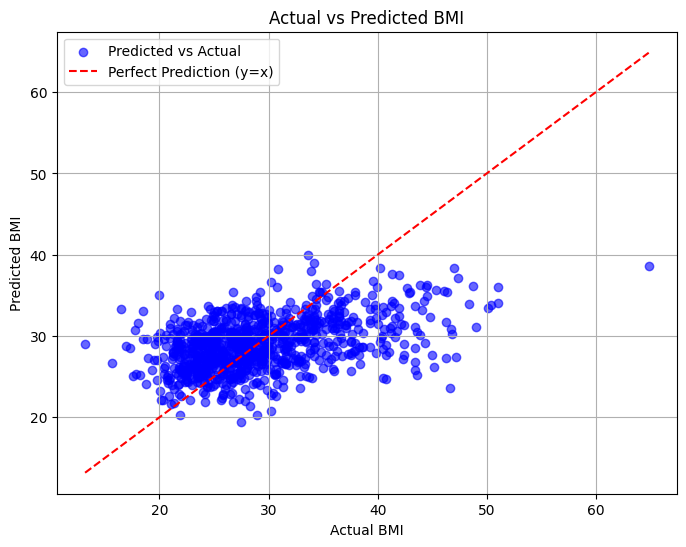

In [9]:
import matplotlib.pyplot as plt

# Plot the actual vs predicted BMI values
plt.figure(figsize=(8, 6))
plt.scatter(y_bmi_test, y_bmi_pred, alpha=0.6, color='blue', label='Predicted vs Actual')
plt.plot([min(y_bmi_test), max(y_bmi_test)], [min(y_bmi_test), max(y_bmi_test)], color='red', linestyle='--', label='Perfect Prediction (y=x)')

# Add labels and title
plt.xlabel("Actual BMI")
plt.ylabel("Predicted BMI")
plt.title("Actual vs Predicted BMI")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


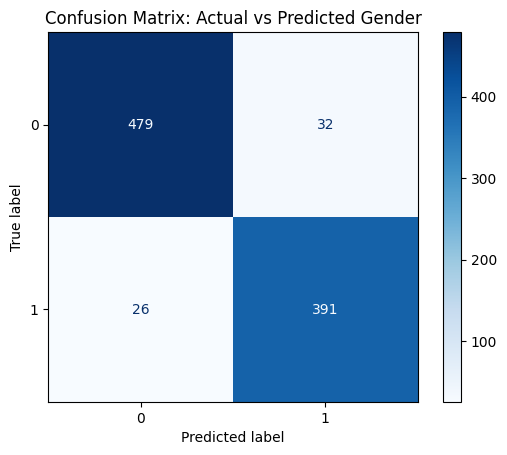

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Plot the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_gender_test, y_gender_pred, cmap='Blues')

# Add title
plt.title("Confusion Matrix: Actual vs Predicted Gender")
plt.show()


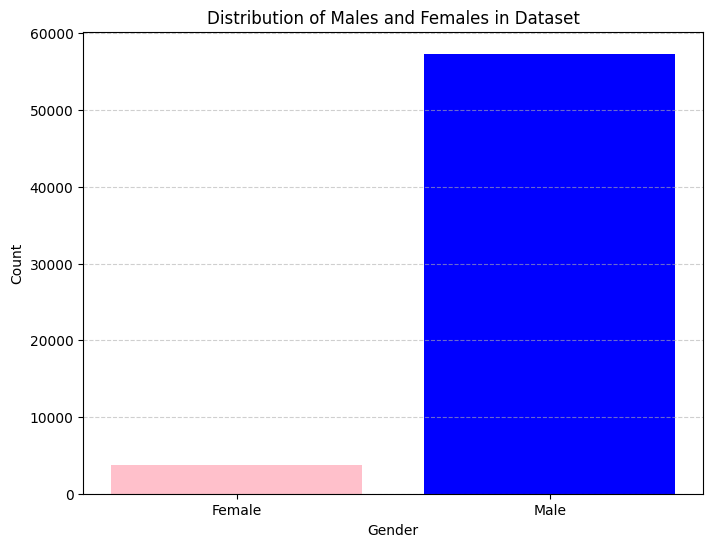

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
data = pd.read_csv("person.csv", sep=";")

# Select relevant columns and clean data
data = data[["sex"]]
data["sex"] = data["sex"].fillna("unknown").apply(lambda x: str(x).strip().lower())  # Handle invalid 'sex'
data = data[data["sex"].isin(["male", "female"])]  # Filter valid rows

data["sex"] = data["sex"].apply(lambda x: 1 if x == "male" else 0)  # Encode sex as binary

# Count the occurrences of each gender in the dataset
gender_counts = data["sex"].value_counts()  

# Bar Plot
plt.figure(figsize=(8, 6))
plt.bar(gender_counts.index, gender_counts.values, color=['blue', 'pink'], tick_label=['Male', 'Female'])

# Add labels, title, and grid
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Distribution of Males and Females in Dataset")
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Show the plot
plt.show()


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

# Load the valid data from the .pkl file
valid_data = pd.read_pickle("preprocessed_data_filtered.pkl")

# Preprocess the data - Filter rows with missing BMI or image data
valid_data = valid_data.dropna(subset=["BMI", "front_image_data", "side_image_data"])

# Prepare features and targets
X_front = np.array(valid_data["front_image_data"].tolist())
X_side = np.array(valid_data["side_image_data"].tolist())
X_combined = np.hstack((X_front, X_side))  # Combine front and side features
y_bmi = valid_data["BMI"].values

# Split the data for BMI regression
X_train, X_test, y_bmi_train, y_bmi_test = train_test_split(
    X_combined, y_bmi, test_size=0.2, random_state=42
)

# Train BMI Prediction Model with KNN Regressor
knn_model = KNeighborsRegressor(n_neighbors=5)  # You can tune `n_neighbors` later
knn_model.fit(X_train, y_bmi_train)

# Predict and evaluate BMI regression
y_bmi_pred = knn_model.predict(X_test)
bmi_mse = mean_squared_error(y_bmi_test, y_bmi_pred)
bmi_mae = mean_absolute_error(y_bmi_test, y_bmi_pred)
bmi_r2 = r2_score(y_bmi_test, y_bmi_pred)

print("\nBMI Prediction Results (Using KNN Regressor):")
print(f"Mean Squared Error: {bmi_mse}")
print(f"Mean Absolute Error: {bmi_mae}")
print(f"R-squared Score: {bmi_r2}")

# Save the KNN model
joblib.dump(knn_model, 'bmi_knn_model.pkl')



BMI Prediction Results (Using KNN Regressor):
Mean Squared Error: 41.255857395487716
Mean Absolute Error: 4.863914125224947
R-squared Score: 0.0063566392789925485


['bmi_knn_model.pkl']

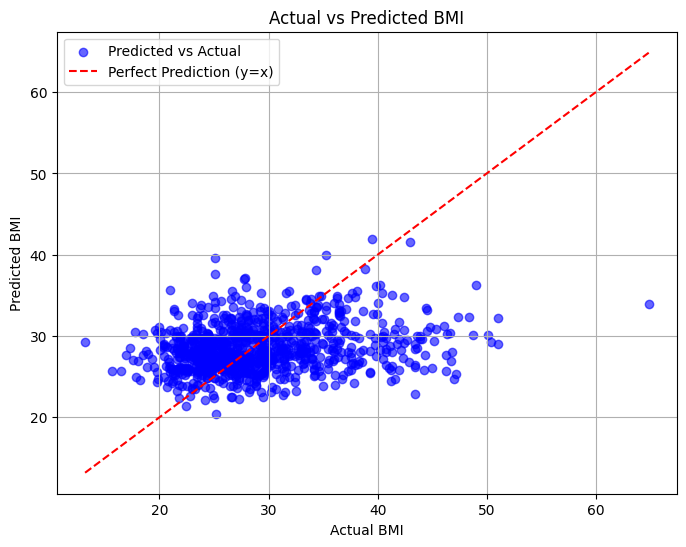

In [2]:
import matplotlib.pyplot as plt

# Plot the actual vs predicted BMI values
plt.figure(figsize=(8, 6))
plt.scatter(y_bmi_test, y_bmi_pred, alpha=0.6, color='blue', label='Predicted vs Actual')
plt.plot([min(y_bmi_test), max(y_bmi_test)], [min(y_bmi_test), max(y_bmi_test)], color='red', linestyle='--', label='Perfect Prediction (y=x)')

# Add labels and title
plt.xlabel("Actual BMI")
plt.ylabel("Predicted BMI")
plt.title("Actual vs Predicted BMI")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
